# IA for HumanForYou

## Context

L'entreprise de produits pharmaceutiques HumanForYou basée en Inde emploie environ 4000 personnes. Cependant, chaque année elle subit un turn-over d'environ 15% de ses employés nécessitant de retrouver des profils similaires sur le marché de l'emploi.

La direction trouve que ce niveau de turn-over n'est pas bon pour l'entreprise car :

Les projets sur lesquels étaient les employés quittant la société prennent du retard ce qui nuit à la réputation de l'entreprise auprès de ses clients et partenaires.

Un service de ressources humaines de taille conséquente doit être conservé car il faut avoir les moyens de trouver les nouvelles recrues.

Du temps est perdu à l'arrivée des nouveaux employés car ils doivent très souvent être formés et ont besoin de temps pour devenir pleinement opérationnels dans leur nouvel environnement.

Le direction fait donc appel à vous, spécialistes de l'analyse de données, pour déterminer les facteurs ayant le plus d'influence sur ce taux de turn-over et lui proposer des modèles afin d'avoir des pistes d'amélioration pour donner à leurs employés l'envie de rester.

Données fournies
Un certain nombre de données concernant les employés vous a donc été transmis par le service des ressources humaines.

Il s'agit de fichiers textes au format CSV.

Les données ont été anonymisées : un employé de l'entreprise sera représenté par le même EmployeeID dans l'ensemble des fichiers qui suivent.


# Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import pandas as pd
from six.moves import urllib
from zipfile import ZipFile
import math
import seaborn as sns
from pandas.plotting import scatter_matrix

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

## Import des données

On va importer toutes les données dans des tableau

In [2]:
DOWNLOAD_ROOT = "https://github.com/Teerath67/Projet-IA/raw/master/data.zip"
DATA_PATH = os.path.join("datasets", "data")

MANAGER_SURVEY_CSV = "manager_survey_data.csv"
EMPLOYEE_SURVEY_CSV = "employee_survey_data.csv"
GENERAL_CSV = "general_data.csv"
IN_TIME_CSV = "in_time.csv"
OUT_TIME_CSV = "out_time.csv"

def fetch_data(download_url=DOWNLOAD_ROOT, data_path=DATA_PATH):
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
    zip_path = os.path.join(data_path, "data.zip")
    urllib.request.urlretrieve(download_url, zip_path)
    data_zip = ZipFile(zip_path, 'r')
    data_zip.extractall(path=data_path)
    data_zip.close()

def load_data(general_path, csv):
    csv_path = os.path.join(general_path, csv)
    df = pd.read_csv(csv_path, sep=",", header = 0)
    return df

fetch_data()

In [3]:
general = load_data(DATA_PATH, GENERAL_CSV)
in_time = load_data(DATA_PATH, IN_TIME_CSV)
out_time = load_data(DATA_PATH, OUT_TIME_CSV)
manager_survey = load_data(DATA_PATH, MANAGER_SURVEY_CSV)
employee_survey = load_data(DATA_PATH, EMPLOYEE_SURVEY_CSV)

## Check des données
On va regarder les prmières lignes des données

In [4]:
general.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,1,Healthcare Representative,Married,131160,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,1,Research Scientist,Single,41890,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,4,Sales Executive,Married,193280,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,3,Human Resources,Married,83210,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,1,Sales Executive,Single,23420,4.0,Y,12,8,2,9.0,2,6,0,4


In [5]:
in_time.head()

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,2015-01-15,2015-01-16,2015-01-19,2015-01-20,2015-01-21,2015-01-22,2015-01-23,2015-01-26,2015-01-27,2015-01-28,2015-01-29,2015-01-30,2015-02-02,2015-02-03,2015-02-04,2015-02-05,2015-02-06,2015-02-09,2015-02-10,2015-02-11,2015-02-12,2015-02-13,2015-02-16,2015-02-17,2015-02-18,2015-02-19,2015-02-20,2015-02-23,2015-02-24,2015-02-25,2015-02-26,2015-02-27,2015-03-02,2015-03-03,2015-03-04,2015-03-05,2015-03-06,2015-03-09,2015-03-10,2015-03-11,2015-03-12,2015-03-13,2015-03-16,2015-03-17,2015-03-18,2015-03-19,2015-03-20,2015-03-23,2015-03-24,2015-03-25,2015-03-26,2015-03-27,2015-03-30,2015-03-31,2015-04-01,2015-04-02,2015-04-03,2015-04-06,2015-04-07,2015-04-08,2015-04-09,2015-04-10,2015-04-13,2015-04-14,2015-04-15,2015-04-16,2015-04-17,2015-04-20,2015-04-21,2015-04-22,2015-04-23,2015-04-24,2015-04-27,2015-04-28,2015-04-29,2015-04-30,2015-05-01,2015-05-04,2015-05-05,2015-05-06,2015-05-07,2015-05-08,2015-05-11,2015-05-12,2015-05-13,2015-05-14,2015-05-15,2015-05-18,2015-05-19,2015-05-20,2015-05-21,2015-05-22,2015-05-25,2015-05-26,2015-05-27,2015-05-28,2015-05-29,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-08,2015-06-09,2015-06-10,2015-06-11,2015-06-12,2015-06-15,2015-06-16,2015-06-17,2015-06-18,2015-06-19,2015-06-22,2015-06-23,2015-06-24,2015-06-25,2015-06-26,2015-06-29,2015-06-30,2015-07-01,2015-07-02,2015-07-03,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-17,2015-08-18,2015-08-19,2015-08-20,2015-08-21,2015-08-24,2015-08-25,2015-08-26,2015-08-27,2015-08-28,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-07,2015-09-08,2015-09-09,2015-09-10,2015-09-11,2015-09-14,2015-09-15,2015-09-16,2015-09-17,2015-09-18,2015-09-21,2015-09-22,2015-09-23,2015-09-24,2015-09-25,2015-09-28,2015-09-29,2015-09-30,2015-10-01,2015-10-02,2015-10-05,2015-10-06,2015-10-07,2015-10-08,2015-10-09,2015-10-12,2015-10-13,2015-10-14,2015-10-15,2015-10-16,2015-10-19,2015-10-20,2015-10-21,2015-10-22,2015-10-23,2015-10-26,2015-10-27,2015-10-28,2015-10-29,2015-10-30,2015-11-02,2015-11-03,2015-11-04,2015-11-05,2015-11-06,2015-11-09,2015-11-10,2015-11-11,2015-11-12,2015-11-13,2015-11-16,2015-11-17,2015-11-18,2015-11-19,2015-11-20,2015-11-23,2015-11-24,2015-11-25,2015-11-26,2015-11-27,2015-11-30,2015-12-01,2015-12-02,2015-12-03,2015-12-04,2015-12-07,2015-12-08,2015-12-09,2015-12-10,2015-12-11,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,NaN,2015-01-15 10:01:24,2015-01-16 10:19:08,NaN,2015-01-20 09:50:34,2015-01-21 09:49:42,2015-01-22 09:47:45,2015-01-23 09:23:44,NaN,2015-01-27 09:50:37,2015-01-28 09:56:13,2015-01-29 09:53:47,2015-01-30 10:09:26,2015-02-02 09:38:43,2015-02-03 10:23:38,2015-02-04 09:48:37,2015-02-05 09:52:36,2015-02-06 09:53:23,2015-02-09 10:01:45,2015-02-10 10:14:18,2015-02-11 10:18:44,2015-02-12 10:10:35,2015-02-13 09:13:07,2015-02-16 10:14:02,2015-02-17 10:03:08,2015-02-18 10:23:06,NaN,2015-02-20 09:54:56,2015-02-23 09:46:59,2015-02-24 10:11:18,2015-02-25 09:52:36,2015-02-26 09:56:33,2015-02-27 09:58:46,2015-03-02 10:19:43,2015-03-03 10:08:37,2015-03-04 10:05:38,NaN,2015-03-06 09:55:53,2015-03-09 10:28:34,2015-03-10 09:47:30,2015-03-11 09:48:59,2015-03-12 10:10:51,2015-03-13 10:07:18,NaN,2015-03-17 10:05:22,2015-03-18 10:28:21,2015-03-19 10:01:52,2015-03-20 10:37:49,2015-03-23 10:11:19,2015-03-24 10:33:19,2015-03-25 09:41:35,NaN,2015-03-27 09:47:30,2

In [6]:
out_time.head()

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,2015-01-15,2015-01-16,2015-01-19,2015-01-20,2015-01-21,2015-01-22,2015-01-23,2015-01-26,2015-01-27,2015-01-28,2015-01-29,2015-01-30,2015-02-02,2015-02-03,2015-02-04,2015-02-05,2015-02-06,2015-02-09,2015-02-10,2015-02-11,2015-02-12,2015-02-13,2015-02-16,2015-02-17,2015-02-18,2015-02-19,2015-02-20,2015-02-23,2015-02-24,2015-02-25,2015-02-26,2015-02-27,2015-03-02,2015-03-03,2015-03-04,2015-03-05,2015-03-06,2015-03-09,2015-03-10,2015-03-11,2015-03-12,2015-03-13,2015-03-16,2015-03-17,2015-03-18,2015-03-19,2015-03-20,2015-03-23,2015-03-24,2015-03-25,2015-03-26,2015-03-27,2015-03-30,2015-03-31,2015-04-01,2015-04-02,2015-04-03,2015-04-06,2015-04-07,2015-04-08,2015-04-09,2015-04-10,2015-04-13,2015-04-14,2015-04-15,2015-04-16,2015-04-17,2015-04-20,2015-04-21,2015-04-22,2015-04-23,2015-04-24,2015-04-27,2015-04-28,2015-04-29,2015-04-30,2015-05-01,2015-05-04,2015-05-05,2015-05-06,2015-05-07,2015-05-08,2015-05-11,2015-05-12,2015-05-13,2015-05-14,2015-05-15,2015-05-18,2015-05-19,2015-05-20,2015-05-21,2015-05-22,2015-05-25,2015-05-26,2015-05-27,2015-05-28,2015-05-29,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-08,2015-06-09,2015-06-10,2015-06-11,2015-06-12,2015-06-15,2015-06-16,2015-06-17,2015-06-18,2015-06-19,2015-06-22,2015-06-23,2015-06-24,2015-06-25,2015-06-26,2015-06-29,2015-06-30,2015-07-01,2015-07-02,2015-07-03,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-17,2015-08-18,2015-08-19,2015-08-20,2015-08-21,2015-08-24,2015-08-25,2015-08-26,2015-08-27,2015-08-28,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-07,2015-09-08,2015-09-09,2015-09-10,2015-09-11,2015-09-14,2015-09-15,2015-09-16,2015-09-17,2015-09-18,2015-09-21,2015-09-22,2015-09-23,2015-09-24,2015-09-25,2015-09-28,2015-09-29,2015-09-30,2015-10-01,2015-10-02,2015-10-05,2015-10-06,2015-10-07,2015-10-08,2015-10-09,2015-10-12,2015-10-13,2015-10-14,2015-10-15,2015-10-16,2015-10-19,2015-10-20,2015-10-21,2015-10-22,2015-10-23,2015-10-26,2015-10-27,2015-10-28,2015-10-29,2015-10-30,2015-11-02,2015-11-03,2015-11-04,2015-11-05,2015-11-06,2015-11-09,2015-11-10,2015-11-11,2015-11-12,2015-11-13,2015-11-16,2015-11-17,2015-11-18,2015-11-19,2015-11-20,2015-11-23,2015-11-24,2015-11-25,2015-11-26,2015-11-27,2015-11-30,2015-12-01,2015-12-02,2015-12-03,2015-12-04,2015-12-07,2015-12-08,2015-12-09,2015-12-10,2015-12-11,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 16:56:15,2015-01-05 17:20:11,2015-01-06 17:19:05,2015-01-07 16:34:55,2015-01-08 17:08:32,2015-01-09 17:38:29,2015-01-12 16:58:39,2015-01-13 18:02:58,NaN,2015-01-15 17:22:13,2015-01-16 17:35:11,NaN,2015-01-20 16:37:07,2015-01-21 16:55:24,2015-01-22 16:50:47,2015-01-23 17:00:01,NaN,2015-01-27 17:28:22,2015-01-28 17:03:21,2015-01-29 17:18:36,2015-01-30 17:00:25,2015-02-02 16:32:49,2015-02-03 17:35:49,2015-02-04 17:24:56,2015-02-05 17:26:31,2015-02-06 17:21:35,2015-02-09 17:37:50,2015-02-10 17:30:20,2015-02-11 17:30:19,2015-02-12 17:36:42,2015-02-13 16:25:26,2015-02-16 17:50:23,2015-02-17 17:28:06,2015-02-18 18:13:29,NaN,2015-02-20 17:44:52,2015-02-23 17:13:27,2015-02-24 17:24:48,2015-02-25 17:27:37,2015-02-26 17:08:36,2015-02-27 17:21:55,2015-03-02 17:29:08,2015-03-03 16:54:12,2015-03-04 17:50:18,NaN,2015-03-06 17:44:47,2015-03-09 17:53:05,2015-03-10 16:42:53,2015-03-11 16:58:39,2015-03-12 17:15:39,2015-03-13 17:25:55,NaN,2015-03-17 17:00:16,2015-03-18 17:40:13,2015-03-19 17:52:44,2015-03-20 17:47:34,2015-03-23 17:48:18,2015-03-24 17:48:26,2015-03-25 17:08:19,NaN,2015-03-27 17:20:51,2

In [7]:
manager_survey.head()

,EmployeeID,JobInvolvement,PerformanceRating
0,1,3,3
1,2,2,4
2,3,3,3
3,4,2,3
4,5,3,3


## Merge des données en un seul tableau

In [8]:
merged_data = general.merge(manager_survey, how='left', on='EmployeeID')

In [9]:
merged_data.value_counts("JobRole")

JobRole
Sales Executive              978
Research Scientist           876
Laboratory Technician        777
Manufacturing Director       435
Healthcare Representative    393
Manager                      306
Sales Representative         249
Research Director            240
Human Resources              156
dtype: int64

In [10]:
def rename_head(df, header):
    for i, col in enumerate(df.columns):
        df.rename({col: header[i]}, axis=1, inplace=True)
    return df

In [11]:
header_in = in_time.columns.to_list()
header_out = out_time.columns.to_list()

In [12]:
header_in[0] = 'EmployeeID'
header_out[0] = 'EmployeeID'

In [13]:
rename_head(in_time, header_in)

,EmployeeID,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,2015-01-15,2015-01-16,2015-01-19,2015-01-20,2015-01-21,2015-01-22,2015-01-23,2015-01-26,2015-01-27,2015-01-28,2015-01-29,2015-01-30,2015-02-02,2015-02-03,2015-02-04,2015-02-05,2015-02-06,2015-02-09,2015-02-10,2015-02-11,2015-02-12,2015-02-13,2015-02-16,2015-02-17,2015-02-18,2015-02-19,2015-02-20,2015-02-23,2015-02-24,2015-02-25,2015-02-26,2015-02-27,2015-03-02,2015-03-03,2015-03-04,2015-03-05,2015-03-06,2015-03-09,2015-03-10,2015-03-11,2015-03-12,2015-03-13,2015-03-16,2015-03-17,2015-03-18,2015-03-19,2015-03-20,2015-03-23,2015-03-24,2015-03-25,2015-03-26,2015-03-27,2015-03-30,2015-03-31,2015-04-01,2015-04-02,2015-04-03,2015-04-06,2015-04-07,2015-04-08,2015-04-09,2015-04-10,2015-04-13,2015-04-14,2015-04-15,2015-04-16,2015-04-17,2015-04-20,2015-04-21,2015-04-22,2015-04-23,2015-04-24,2015-04-27,2015-04-28,2015-04-29,2015-04-30,2015-05-01,2015-05-04,2015-05-05,2015-05-06,2015-05-07,2015-05-08,2015-05-11,2015-05-12,2015-05-13,2015-05-14,2015-05-15,2015-05-18,2015-05-19,2015-05-20,2015-05-21,2015-05-22,2015-05-25,2015-05-26,2015-05-27,2015-05-28,2015-05-29,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-08,2015-06-09,2015-06-10,2015-06-11,2015-06-12,2015-06-15,2015-06-16,2015-06-17,2015-06-18,2015-06-19,2015-06-22,2015-06-23,2015-06-24,2015-06-25,2015-06-26,2015-06-29,2015-06-30,2015-07-01,2015-07-02,2015-07-03,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-17,2015-08-18,2015-08-19,2015-08-20,2015-08-21,2015-08-24,2015-08-25,2015-08-26,2015-08-27,2015-08-28,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-07,2015-09-08,2015-09-09,2015-09-10,2015-09-11,2015-09-14,2015-09-15,2015-09-16,2015-09-17,2015-09-18,2015-09-21,2015-09-22,2015-09-23,2015-09-24,2015-09-25,2015-09-28,2015-09-29,2015-09-30,2015-10-01,2015-10-02,2015-10-05,2015-10-06,2015-10-07,2015-10-08,2015-10-09,2015-10-12,2015-10-13,2015-10-14,2015-10-15,2015-10-16,2015-10-19,2015-10-20,2015-10-21,2015-10-22,2015-10-23,2015-10-26,2015-10-27,2015-10-28,2015-10-29,2015-10-30,2015-11-02,2015-11-03,2015-11-04,2015-11-05,2015-11-06,2015-11-09,2015-11-10,2015-11-11,2015-11-12,2015-11-13,2015-11-16,2015-11-17,2015-11-18,2015-11-19,2015-11-20,2015-11-23,2015-11-24,2015-11-25,2015-11-26,2015-11-27,2015-11-30,2015-12-01,2015-12-02,2015-12-03,2015-12-04,2015-12-07,2015-12-08,2015-12-09,2015-12-10,2015-12-11,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,NaN,2015-01-15 10:01:24,2015-01-16 10:19:08,NaN,2015-01-20 09:50:34,2015-01-21 09:49:42,2015-01-22 09:47:45,2015-01-23 09:23:44,NaN,2015-01-27 09:50:37,2015-01-28 09:56:13,2015-01-29 09:53:47,2015-01-30 10:09:26,2015-02-02 09:38:43,2015-02-03 10:23:38,2015-02-04 09:48:37,2015-02-05 09:52:36,2015-02-06 09:53:23,2015-02-09 10:01:45,2015-02-10 10:14:18,2015-02-11 10:18:44,2015-02-12 10:10:35,2015-02-13 09:13:07,2015-02-16 10:14:02,2015-02-17 10:03:08,2015-02-18 10:23:06,NaN,2015-02-20 09:54:56,2015-02-23 09:46:59,2015-02-24 10:11:18,2015-02-25 09:52:36,2015-02-26 09:56:33,2015-02-27 09:58:46,2015-03-02 10:19:43,2015-03-03 10:08:37,2015-03-04 10:05:38,NaN,2015-03-06 09:55:53,2015-03-09 10:28:34,2015-03-10 09:47:30,2015-03-11 09:48:59,2015-03-12 10:10:51,2015-03-13 10:07:18,NaN,2015-03-17 10:05:22,2015-03-18 10:28:21,2015-03-19 10:01:52,2015-03-20 10:37:49,2015-03-23 10:11:19,2015-03-24 10:33:19,2015-03-25 09:41:35,NaN,2015-03-27 09:47:30,2

In [14]:
rename_head(out_time, header_out)

,EmployeeID,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,2015-01-15,2015-01-16,2015-01-19,2015-01-20,2015-01-21,2015-01-22,2015-01-23,2015-01-26,2015-01-27,2015-01-28,2015-01-29,2015-01-30,2015-02-02,2015-02-03,2015-02-04,2015-02-05,2015-02-06,2015-02-09,2015-02-10,2015-02-11,2015-02-12,2015-02-13,2015-02-16,2015-02-17,2015-02-18,2015-02-19,2015-02-20,2015-02-23,2015-02-24,2015-02-25,2015-02-26,2015-02-27,2015-03-02,2015-03-03,2015-03-04,2015-03-05,2015-03-06,2015-03-09,2015-03-10,2015-03-11,2015-03-12,2015-03-13,2015-03-16,2015-03-17,2015-03-18,2015-03-19,2015-03-20,2015-03-23,2015-03-24,2015-03-25,2015-03-26,2015-03-27,2015-03-30,2015-03-31,2015-04-01,2015-04-02,2015-04-03,2015-04-06,2015-04-07,2015-04-08,2015-04-09,2015-04-10,2015-04-13,2015-04-14,2015-04-15,2015-04-16,2015-04-17,2015-04-20,2015-04-21,2015-04-22,2015-04-23,2015-04-24,2015-04-27,2015-04-28,2015-04-29,2015-04-30,2015-05-01,2015-05-04,2015-05-05,2015-05-06,2015-05-07,2015-05-08,2015-05-11,2015-05-12,2015-05-13,2015-05-14,2015-05-15,2015-05-18,2015-05-19,2015-05-20,2015-05-21,2015-05-22,2015-05-25,2015-05-26,2015-05-27,2015-05-28,2015-05-29,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-08,2015-06-09,2015-06-10,2015-06-11,2015-06-12,2015-06-15,2015-06-16,2015-06-17,2015-06-18,2015-06-19,2015-06-22,2015-06-23,2015-06-24,2015-06-25,2015-06-26,2015-06-29,2015-06-30,2015-07-01,2015-07-02,2015-07-03,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-17,2015-08-18,2015-08-19,2015-08-20,2015-08-21,2015-08-24,2015-08-25,2015-08-26,2015-08-27,2015-08-28,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-07,2015-09-08,2015-09-09,2015-09-10,2015-09-11,2015-09-14,2015-09-15,2015-09-16,2015-09-17,2015-09-18,2015-09-21,2015-09-22,2015-09-23,2015-09-24,2015-09-25,2015-09-28,2015-09-29,2015-09-30,2015-10-01,2015-10-02,2015-10-05,2015-10-06,2015-10-07,2015-10-08,2015-10-09,2015-10-12,2015-10-13,2015-10-14,2015-10-15,2015-10-16,2015-10-19,2015-10-20,2015-10-21,2015-10-22,2015-10-23,2015-10-26,2015-10-27,2015-10-28,2015-10-29,2015-10-30,2015-11-02,2015-11-03,2015-11-04,2015-11-05,2015-11-06,2015-11-09,2015-11-10,2015-11-11,2015-11-12,2015-11-13,2015-11-16,2015-11-17,2015-11-18,2015-11-19,2015-11-20,2015-11-23,2015-11-24,2015-11-25,2015-11-26,2015-11-27,2015-11-30,2015-12-01,2015-12-02,2015-12-03,2015-12-04,2015-12-07,2015-12-08,2015-12-09,2015-12-10,2015-12-11,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 16:56:15,2015-01-05 17:20:11,2015-01-06 17:19:05,2015-01-07 16:34:55,2015-01-08 17:08:32,2015-01-09 17:38:29,2015-01-12 16:58:39,2015-01-13 18:02:58,NaN,2015-01-15 17:22:13,2015-01-16 17:35:11,NaN,2015-01-20 16:37:07,2015-01-21 16:55:24,2015-01-22 16:50:47,2015-01-23 17:00:01,NaN,2015-01-27 17:28:22,2015-01-28 17:03:21,2015-01-29 17:18:36,2015-01-30 17:00:25,2015-02-02 16:32:49,2015-02-03 17:35:49,2015-02-04 17:24:56,2015-02-05 17:26:31,2015-02-06 17:21:35,2015-02-09 17:37:50,2015-02-10 17:30:20,2015-02-11 17:30:19,2015-02-12 17:36:42,2015-02-13 16:25:26,2015-02-16 17:50:23,2015-02-17 17:28:06,2015-02-18 18:13:29,NaN,2015-02-20 17:44:52,2015-02-23 17:13:27,2015-02-24 17:24:48,2015-02-25 17:27:37,2015-02-26 17:08:36,2015-02-27 17:21:55,2015-03-02 17:29:08,2015-03-03 16:54:12,2015-03-04 17:50:18,NaN,2015-03-06 17:44:47,2015-03-09 17:53:05,2015-03-10 16:42:53,2015-03-11 16:58:39,2015-03-12 17:15:39,2015-03-13 17:25:55,NaN,2015-03-17 17:00:16,2015-03-18 17:40:13,2015-03-19 17:52:44,2015-03-20 17:47:34,2015-03-23 17:48:18,2015-03-24 17:48:26,2015-03-25 17:08:19,NaN,2015-03-27 17:20:51,2

In [15]:
time_frame = in_time.merge(out_time, how='left', on='EmployeeID')

In [16]:
time_frame

,EmployeeID,2015-01-01_x,2015-01-02_x,2015-01-05_x,2015-01-06_x,2015-01-07_x,2015-01-08_x,2015-01-09_x,2015-01-12_x,2015-01-13_x,2015-01-14_x,2015-01-15_x,2015-01-16_x,2015-01-19_x,2015-01-20_x,2015-01-21_x,2015-01-22_x,2015-01-23_x,2015-01-26_x,2015-01-27_x,2015-01-28_x,2015-01-29_x,2015-01-30_x,2015-02-02_x,2015-02-03_x,2015-02-04_x,2015-02-05_x,2015-02-06_x,2015-02-09_x,2015-02-10_x,2015-02-11_x,2015-02-12_x,2015-02-13_x,2015-02-16_x,2015-02-17_x,2015-02-18_x,2015-02-19_x,2015-02-20_x,2015-02-23_x,2015-02-24_x,2015-02-25_x,2015-02-26_x,2015-02-27_x,2015-03-02_x,2015-03-03_x,2015-03-04_x,2015-03-05_x,2015-03-06_x,2015-03-09_x,2015-03-10_x,2015-03-11_x,2015-03-12_x,2015-03-13_x,2015-03-16_x,2015-03-17_x,2015-03-18_x,2015-03-19_x,2015-03-20_x,2015-03-23_x,2015-03-24_x,2015-03-25_x,2015-03-26_x,2015-03-27_x,2015-03-30_x,2015-03-31_x,2015-04-01_x,2015-04-02_x,2015-04-03_x,2015-04-06_x,2015-04-07_x,2015-04-08_x,2015-04-09_x,2015-04-10_x,2015-04-13_x,2015-04-14_x,2015-04-15_x,2015-04-16_x,2015-04-17_x,2015-04-20_x,2015-04-21_x,2015-04-22_x,2015-04-23_x,2015-04-24_x,2015-04-27_x,2015-04-28_x,2015-04-29_x,2015-04-30_x,2015-05-01_x,2015-05-04_x,2015-05-05_x,2015-05-06_x,2015-05-07_x,2015-05-08_x,2015-05-11_x,2015-05-12_x,2015-05-13_x,2015-05-14_x,2015-05-15_x,2015-05-18_x,2015-05-19_x,2015-05-20_x,2015-05-21_x,2015-05-22_x,2015-05-25_x,2015-05-26_x,2015-05-27_x,2015-05-28_x,2015-05-29_x,2015-06-01_x,2015-06-02_x,2015-06-03_x,2015-06-04_x,2015-06-05_x,2015-06-08_x,2015-06-09_x,2015-06-10_x,2015-06-11_x,2015-06-12_x,2015-06-15_x,2015-06-16_x,2015-06-17_x,2015-06-18_x,2015-06-19_x,2015-06-22_x,2015-06-23_x,2015-06-24_x,2015-06-25_x,2015-06-26_x,2015-06-29_x,2015-06-30_x,2015-07-01_x,2015-07-02_x,2015-07-03_x,2015-07-06_x,2015-07-07_x,2015-07-08_x,2015-07-09_x,2015-07-10_x,2015-07-13_x,2015-07-14_x,2015-07-15_x,2015-07-16_x,2015-07-17_x,2015-07-20_x,2015-07-21_x,2015-07-22_x,2015-07-23_x,2015-07-24_x,2015-07-27_x,2015-07-28_x,2015-07-29_x,2015-07-30_x,2015-07-31_x,2015-08-03_x,2015-08-04_x,2015-08-05_x,2015-08-06_x,2015-08-07_x,2015-08-10_x,2015-08-11_x,2015-08-12_x,2015-08-13_x,2015-08-14_x,2015-08-17_x,2015-08-18_x,2015-08-19_x,2015-08-20_x,2015-08-21_x,2015-08-24_x,2015-08-25_x,2015-08-26_x,2015-08-27_x,2015-08-28_x,2015-08-31_x,2015-09-01_x,2015-09-02_x,2015-09-03_x,2015-09-04_x,2015-09-07_x,2015-09-08_x,2015-09-09_x,2015-09-10_x,2015-09-11_x,2015-09-14_x,2015-09-15_x,2015-09-16_x,2015-09-17_x,2015-09-18_x,2015-09-21_x,2015-09-22_x,2015-09-23_x,2015-09-24_x,2015-09-25_x,2015-09-28_x,2015-09-29_x,2015-09-30_x,2015-10-01_x,2015-10-02_x,2015-10-05_x,2015-10-06_x,2015-10-07_x,2015-10-08_x,2015-10-09_x,2015-10-12_x,2015-10-13_x,2015-10-14_x,2015-10-15_x,2015-10-16_x,2015-10-19_x,2015-10-20_x,2015-10-21_x,2015-10-22_x,2015-10-23_x,2015-10-26_x,2015-10-27_x,2015-10-28_x,2015-10-29_x,2015-10-30_x,2015-11-02_x,2015-11-03_x,2015-11-04_x,2015-11-05_x,2015-11-06_x,2015-11-09_x,2015-11-10_x,2015-11-11_x,2015-11-12_x,2015-11-13_x,2015-11-16_x,2015-11-17_x,2015-11-18_x,2015-11-19_x,2015-11-20_x,2015-11-23_x,2015-11-24_x,2015-11-25_x,2015-11-26_x,2015-11-27_x,2015-11-30_x,2015-12-01_x,2015-12-02_x,2015-12-03_x,2015-12-04_x,2015-12-07_x,2015-12-08_x,2015-12-09_x,2015-12-10_x,2015-12-11_x,2015-12-14_x,2015-12-15_x,...,2015-01-16_y,2015-01-19_y,2015-01-20_y,2015-01-21_y,2015-01-22_y,2015-01-23_y,2015-01-26_y,2015-01-27_y,2015-01-28_y,2015-01-29_y,2015-01-30_y,2015-02-02_y,2015-02-03_y,2015-02-04_y,2015-02-05_y,2015-02-06_y,2015-02-09_y,2015-02-10_y,2015-02-11_y,2015-02-12_y,2015-02-13_y,2015-02-16_y,2015-02-17_y,2015-02-18_y,2015-02-19_y,2015-02-20_y,2015-02-23_y,2015-02-24_y,2015-02-25_y,2015-02-26_y,2015-02-27_y,2015-03-02_y,2015-03-03_y,2015-03-04_y,2015-03-05_y,2015-03-06_y,2015-03-09_y,2015-03-10_y,2015-03-11_y,2015-03-12_y,2015-03-13_y,2015-03-16_y,2015-03-17_y,2015-03-18_y,2015-03-19_y,2015-03-20_y,2015-03-23_y,2015-03-24_y,2015-03-25_y,2015-03-26_y,2015-03-27_y,2015-03-30_y,2015-03-31_y,2015-04-01_y,2015-04-02_y,2015-04-03_y,2015-04-06_y,2015-0

In [17]:
time_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Columns: 523 entries, EmployeeID to 2015-12-31_y
dtypes: float64(24), int64(1), object(498)
memory usage: 17.6+ MB


In [18]:
time_frame.iloc[:,1:]

,2015-01-01_x,2015-01-02_x,2015-01-05_x,2015-01-06_x,2015-01-07_x,2015-01-08_x,2015-01-09_x,2015-01-12_x,2015-01-13_x,2015-01-14_x,2015-01-15_x,2015-01-16_x,2015-01-19_x,2015-01-20_x,2015-01-21_x,2015-01-22_x,2015-01-23_x,2015-01-26_x,2015-01-27_x,2015-01-28_x,2015-01-29_x,2015-01-30_x,2015-02-02_x,2015-02-03_x,2015-02-04_x,2015-02-05_x,2015-02-06_x,2015-02-09_x,2015-02-10_x,2015-02-11_x,2015-02-12_x,2015-02-13_x,2015-02-16_x,2015-02-17_x,2015-02-18_x,2015-02-19_x,2015-02-20_x,2015-02-23_x,2015-02-24_x,2015-02-25_x,2015-02-26_x,2015-02-27_x,2015-03-02_x,2015-03-03_x,2015-03-04_x,2015-03-05_x,2015-03-06_x,2015-03-09_x,2015-03-10_x,2015-03-11_x,2015-03-12_x,2015-03-13_x,2015-03-16_x,2015-03-17_x,2015-03-18_x,2015-03-19_x,2015-03-20_x,2015-03-23_x,2015-03-24_x,2015-03-25_x,2015-03-26_x,2015-03-27_x,2015-03-30_x,2015-03-31_x,2015-04-01_x,2015-04-02_x,2015-04-03_x,2015-04-06_x,2015-04-07_x,2015-04-08_x,2015-04-09_x,2015-04-10_x,2015-04-13_x,2015-04-14_x,2015-04-15_x,2015-04-16_x,2015-04-17_x,2015-04-20_x,2015-04-21_x,2015-04-22_x,2015-04-23_x,2015-04-24_x,2015-04-27_x,2015-04-28_x,2015-04-29_x,2015-04-30_x,2015-05-01_x,2015-05-04_x,2015-05-05_x,2015-05-06_x,2015-05-07_x,2015-05-08_x,2015-05-11_x,2015-05-12_x,2015-05-13_x,2015-05-14_x,2015-05-15_x,2015-05-18_x,2015-05-19_x,2015-05-20_x,2015-05-21_x,2015-05-22_x,2015-05-25_x,2015-05-26_x,2015-05-27_x,2015-05-28_x,2015-05-29_x,2015-06-01_x,2015-06-02_x,2015-06-03_x,2015-06-04_x,2015-06-05_x,2015-06-08_x,2015-06-09_x,2015-06-10_x,2015-06-11_x,2015-06-12_x,2015-06-15_x,2015-06-16_x,2015-06-17_x,2015-06-18_x,2015-06-19_x,2015-06-22_x,2015-06-23_x,2015-06-24_x,2015-06-25_x,2015-06-26_x,2015-06-29_x,2015-06-30_x,2015-07-01_x,2015-07-02_x,2015-07-03_x,2015-07-06_x,2015-07-07_x,2015-07-08_x,2015-07-09_x,2015-07-10_x,2015-07-13_x,2015-07-14_x,2015-07-15_x,2015-07-16_x,2015-07-17_x,2015-07-20_x,2015-07-21_x,2015-07-22_x,2015-07-23_x,2015-07-24_x,2015-07-27_x,2015-07-28_x,2015-07-29_x,2015-07-30_x,2015-07-31_x,2015-08-03_x,2015-08-04_x,2015-08-05_x,2015-08-06_x,2015-08-07_x,2015-08-10_x,2015-08-11_x,2015-08-12_x,2015-08-13_x,2015-08-14_x,2015-08-17_x,2015-08-18_x,2015-08-19_x,2015-08-20_x,2015-08-21_x,2015-08-24_x,2015-08-25_x,2015-08-26_x,2015-08-27_x,2015-08-28_x,2015-08-31_x,2015-09-01_x,2015-09-02_x,2015-09-03_x,2015-09-04_x,2015-09-07_x,2015-09-08_x,2015-09-09_x,2015-09-10_x,2015-09-11_x,2015-09-14_x,2015-09-15_x,2015-09-16_x,2015-09-17_x,2015-09-18_x,2015-09-21_x,2015-09-22_x,2015-09-23_x,2015-09-24_x,2015-09-25_x,2015-09-28_x,2015-09-29_x,2015-09-30_x,2015-10-01_x,2015-10-02_x,2015-10-05_x,2015-10-06_x,2015-10-07_x,2015-10-08_x,2015-10-09_x,2015-10-12_x,2015-10-13_x,2015-10-14_x,2015-10-15_x,2015-10-16_x,2015-10-19_x,2015-10-20_x,2015-10-21_x,2015-10-22_x,2015-10-23_x,2015-10-26_x,2015-10-27_x,2015-10-28_x,2015-10-29_x,2015-10-30_x,2015-11-02_x,2015-11-03_x,2015-11-04_x,2015-11-05_x,2015-11-06_x,2015-11-09_x,2015-11-10_x,2015-11-11_x,2015-11-12_x,2015-11-13_x,2015-11-16_x,2015-11-17_x,2015-11-18_x,2015-11-19_x,2015-11-20_x,2015-11-23_x,2015-11-24_x,2015-11-25_x,2015-11-26_x,2015-11-27_x,2015-11-30_x,2015-12-01_x,2015-12-02_x,2015-12-03_x,2015-12-04_x,2015-12-07_x,2015-12-08_x,2015-12-09_x,2015-12-10_x,2015-12-11_x,2015-12-14_x,2015-12-15_x,2015-12-16_x,...,2015-01-16_y,2015-01-19_y,2015-01-20_y,2015-01-21_y,2015-01-22_y,2015-01-23_y,2015-01-26_y,2015-01-27_y,2015-01-28_y,2015-01-29_y,2015-01-30_y,2015-02-02_y,2015-02-03_y,2015-02-04_y,2015-02-05_y,2015-02-06_y,2015-02-09_y,2015-02-10_y,2015-02-11_y,2015-02-12_y,2015-02-13_y,2015-02-16_y,2015-02-17_y,2015-02-18_y,2015-02-19_y,2015-02-20_y,2015-02-23_y,2015-02-24_y,2015-02-25_y,2015-02-26_y,2015-02-27_y,2015-03-02_y,2015-03-03_y,2015-03-04_y,2015-03-05_y,2015-03-06_y,2015-03-09_y,2015-03-10_y,2015-03-11_y,2015-03-12_y,2015-03-13_y,2015-03-16_y,2015-03-17_y,2015-03-18_y,2015-03-19_y,2015-03-20_y,2015-03-23_y,2015-03-24_y,2015-03-25_y,2015-03-26_y,2015-03-27_y,2015-03-30_y,2015-03-31_y,2015-04-01_y,2015-04-02_y,2015-04-03_y,2015-04-06_y,2015

In [19]:
in_time.iloc[:,1:]= in_time.iloc[:,1:].apply(pd.to_datetime, errors='coerce')

In [20]:
out_time.iloc[:,1:]= out_time.iloc[:,1:].apply(pd.to_datetime, errors='coerce')

In [21]:
import datetime
from datetime import timedelta

def to_hour_td(td):
    return td.transform(lambda x: x.seconds/3600)

processed_df = out_time - in_time
processed_df["EmployeeID"] = out_time["EmployeeID"]

mean_presence_time_df = processed_df.iloc[:, 1:].apply(to_hour_td)

In [22]:
final_time_df = pd.DataFrame()
final_time_df["meanPresenceTime"] = mean_presence_time_df.mean(axis=1)
final_time_df["EmployeeID"] = out_time["EmployeeID"]

In [23]:
processed_df

,EmployeeID,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,2015-01-15,2015-01-16,2015-01-19,2015-01-20,2015-01-21,2015-01-22,2015-01-23,2015-01-26,2015-01-27,2015-01-28,2015-01-29,2015-01-30,2015-02-02,2015-02-03,2015-02-04,2015-02-05,2015-02-06,2015-02-09,2015-02-10,2015-02-11,2015-02-12,2015-02-13,2015-02-16,2015-02-17,2015-02-18,2015-02-19,2015-02-20,2015-02-23,2015-02-24,2015-02-25,2015-02-26,2015-02-27,2015-03-02,2015-03-03,2015-03-04,2015-03-05,2015-03-06,2015-03-09,2015-03-10,2015-03-11,2015-03-12,2015-03-13,2015-03-16,2015-03-17,2015-03-18,2015-03-19,2015-03-20,2015-03-23,2015-03-24,2015-03-25,2015-03-26,2015-03-27,2015-03-30,2015-03-31,2015-04-01,2015-04-02,2015-04-03,2015-04-06,2015-04-07,2015-04-08,2015-04-09,2015-04-10,2015-04-13,2015-04-14,2015-04-15,2015-04-16,2015-04-17,2015-04-20,2015-04-21,2015-04-22,2015-04-23,2015-04-24,2015-04-27,2015-04-28,2015-04-29,2015-04-30,2015-05-01,2015-05-04,2015-05-05,2015-05-06,2015-05-07,2015-05-08,2015-05-11,2015-05-12,2015-05-13,2015-05-14,2015-05-15,2015-05-18,2015-05-19,2015-05-20,2015-05-21,2015-05-22,2015-05-25,2015-05-26,2015-05-27,2015-05-28,2015-05-29,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-08,2015-06-09,2015-06-10,2015-06-11,2015-06-12,2015-06-15,2015-06-16,2015-06-17,2015-06-18,2015-06-19,2015-06-22,2015-06-23,2015-06-24,2015-06-25,2015-06-26,2015-06-29,2015-06-30,2015-07-01,2015-07-02,2015-07-03,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-17,2015-08-18,2015-08-19,2015-08-20,2015-08-21,2015-08-24,2015-08-25,2015-08-26,2015-08-27,2015-08-28,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-07,2015-09-08,2015-09-09,2015-09-10,2015-09-11,2015-09-14,2015-09-15,2015-09-16,2015-09-17,2015-09-18,2015-09-21,2015-09-22,2015-09-23,2015-09-24,2015-09-25,2015-09-28,2015-09-29,2015-09-30,2015-10-01,2015-10-02,2015-10-05,2015-10-06,2015-10-07,2015-10-08,2015-10-09,2015-10-12,2015-10-13,2015-10-14,2015-10-15,2015-10-16,2015-10-19,2015-10-20,2015-10-21,2015-10-22,2015-10-23,2015-10-26,2015-10-27,2015-10-28,2015-10-29,2015-10-30,2015-11-02,2015-11-03,2015-11-04,2015-11-05,2015-11-06,2015-11-09,2015-11-10,2015-11-11,2015-11-12,2015-11-13,2015-11-16,2015-11-17,2015-11-18,2015-11-19,2015-11-20,2015-11-23,2015-11-24,2015-11-25,2015-11-26,2015-11-27,2015-11-30,2015-12-01,2015-12-02,2015-12-03,2015-12-04,2015-12-07,2015-12-08,2015-12-09,2015-12-10,2015-12-11,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaT,0 days 07:12:30,0 days 07:11:23,0 days 07:24:39,0 days 07:00:24,0 days 07:17:23,0 days 07:29:04,0 days 07:15:46,0 days 07:49:52,NaT,0 days 07:20:49,0 days 07:16:03,NaT,0 days 06:46:33,0 days 07:05:42,0 days 07:03:02,0 days 07:36:17,NaT,0 days 07:37:45,0 days 07:07:08,0 days 07:24:49,0 days 06:50:59,0 days 06:54:06,0 days 07:12:11,0 days 07:36:19,0 days 07:33:55,0 days 07:28:12,0 days 07:36:05,0 days 07:16:02,0 days 07:11:35,0 days 07:26:07,0 days 07:12:19,0 days 07:36:21,0 days 07:24:58,0 days 07:50:23,NaT,0 days 07:49:56,0 days 07:26:28,0 days 07:13:30,0 days 07:35:01,0 days 07:12:03,0 days 07:23:09,0 days 07:09:25,0 days 06:45:35,0 days 07:44:40,NaT,0 days 07:48:54,0 days 07:24:31,0 days 06:55:23,0 days 07:09:40,0 days 07:04:48,0 days 07:18:37,NaT,0 days 06:54:54,0 days 07:11:52,0 days 07:50:52,0 days 07:09:45,0 days 07:36:59,0 days 07:15:07,0 days 07:26:44,NaT,0 days 07:33:21,0 days 07:21:25,0 days 07:51:54,0 days 07:20:13,0 days 07:39:31,0 days 07:11:16,0 days 07:02:27,0 days 07:38:24,0 days 07:25:38,0 days 07:48:11,0 days 07:06:57,0 days 07:20:53,0 days 07:08:48,0 days 07:27:35,0 days 07

In [24]:
processed_df.iloc[:, 1:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Columns: 261 entries, 2015-01-01 to 2015-12-31
dtypes: timedelta64[ns](261)
memory usage: 8.8 MB


In [25]:
mean_presence_time_df

,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,2015-01-15,2015-01-16,2015-01-19,2015-01-20,2015-01-21,2015-01-22,2015-01-23,2015-01-26,2015-01-27,2015-01-28,2015-01-29,2015-01-30,2015-02-02,2015-02-03,2015-02-04,2015-02-05,2015-02-06,2015-02-09,2015-02-10,2015-02-11,2015-02-12,2015-02-13,2015-02-16,2015-02-17,2015-02-18,2015-02-19,2015-02-20,2015-02-23,2015-02-24,2015-02-25,2015-02-26,2015-02-27,2015-03-02,2015-03-03,2015-03-04,2015-03-05,2015-03-06,2015-03-09,2015-03-10,2015-03-11,2015-03-12,2015-03-13,2015-03-16,2015-03-17,2015-03-18,2015-03-19,2015-03-20,2015-03-23,2015-03-24,2015-03-25,2015-03-26,2015-03-27,2015-03-30,2015-03-31,2015-04-01,2015-04-02,2015-04-03,2015-04-06,2015-04-07,2015-04-08,2015-04-09,2015-04-10,2015-04-13,2015-04-14,2015-04-15,2015-04-16,2015-04-17,2015-04-20,2015-04-21,2015-04-22,2015-04-23,2015-04-24,2015-04-27,2015-04-28,2015-04-29,2015-04-30,2015-05-01,2015-05-04,2015-05-05,2015-05-06,2015-05-07,2015-05-08,2015-05-11,2015-05-12,2015-05-13,2015-05-14,2015-05-15,2015-05-18,2015-05-19,2015-05-20,2015-05-21,2015-05-22,2015-05-25,2015-05-26,2015-05-27,2015-05-28,2015-05-29,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-08,2015-06-09,2015-06-10,2015-06-11,2015-06-12,2015-06-15,2015-06-16,2015-06-17,2015-06-18,2015-06-19,2015-06-22,2015-06-23,2015-06-24,2015-06-25,2015-06-26,2015-06-29,2015-06-30,2015-07-01,2015-07-02,2015-07-03,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-17,2015-08-18,2015-08-19,2015-08-20,2015-08-21,2015-08-24,2015-08-25,2015-08-26,2015-08-27,2015-08-28,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-07,2015-09-08,2015-09-09,2015-09-10,2015-09-11,2015-09-14,2015-09-15,2015-09-16,2015-09-17,2015-09-18,2015-09-21,2015-09-22,2015-09-23,2015-09-24,2015-09-25,2015-09-28,2015-09-29,2015-09-30,2015-10-01,2015-10-02,2015-10-05,2015-10-06,2015-10-07,2015-10-08,2015-10-09,2015-10-12,2015-10-13,2015-10-14,2015-10-15,2015-10-16,2015-10-19,2015-10-20,2015-10-21,2015-10-22,2015-10-23,2015-10-26,2015-10-27,2015-10-28,2015-10-29,2015-10-30,2015-11-02,2015-11-03,2015-11-04,2015-11-05,2015-11-06,2015-11-09,2015-11-10,2015-11-11,2015-11-12,2015-11-13,2015-11-16,2015-11-17,2015-11-18,2015-11-19,2015-11-20,2015-11-23,2015-11-24,2015-11-25,2015-11-26,2015-11-27,2015-11-30,2015-12-01,2015-12-02,2015-12-03,2015-12-04,2015-12-07,2015-12-08,2015-12-09,2015-12-10,2015-12-11,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,NaN,7.208333,7.189722,7.410833,7.006667,7.289722,7.484444,7.262778,7.831111,NaN,7.346944,7.267500,NaN,6.775833,7.095000,7.050556,7.604722,NaN,7.629167,7.118889,7.413611,6.849722,6.901667,7.203056,7.605278,7.565278,7.470000,7.601389,7.267222,7.193056,7.435278,7.205278,7.605833,7.416111,7.839722,NaN,7.832222,7.441111,7.225000,7.583611,7.200833,7.385833,7.156944,6.759722,7.744444,NaN,7.815000,7.408611,6.923056,7.161111,7.080000,7.310278,NaN,6.915000,7.197778,7.847778,7.162500,7.616389,7.251944,7.445556,NaN,7.555833,7.356944,7.865000,7.336944,7.658611,7.187778,7.040833,7.640000,7.427222,7.803056,7.115833,7.348056,7.146667,7.459722,7.756944,7.284722,7.695278,6.975556,7.525000,7.336389,7.562500,7.241944,7.889167,7.691667,7.508056,NaN,7.410556,7.308611,7.456667,7.062778,7.615000,NaN,7.444722,7.502500,7.901667,6.816944,NaN,7.333056,7.319444,7.465278,7.128889,7.573056,7.199722,7.877778,7.447778,NaN,NaN,7.717222,7.514167,7.041944,NaN,7.072778,NaN,7.075278,7.575000,7.421389,7.595278,7.542222,7.526111,7.521389,7.248889,7.178333,6.912778,7.112778,7.753611,7.052222,7.661667,7.303056,7.723611,7.618333,7.158889,7.947500,7.65

In [26]:
final_time_df

,meanPresenceTime,EmployeeID
0,7.373651,1
1,7.718969,2
2,7.013240,3
3,7.193678,4
4,8.006175,5
...,...,...
4405,8.522277,4406
4406,6.092954,4407
4407,7.706632,4408
4408,9.492595,4409


array([[<AxesSubplot:title={'center':'meanPresenceTime'}>,
        <AxesSubplot:title={'center':'EmployeeID'}>]], dtype=object)

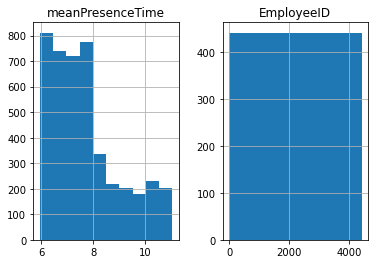

In [27]:
final_time_df.hist()

On rajoute le temps moyen effectué par les employés

In [28]:
general = general.merge(final_time_df, how='left', on='EmployeeID')

In [29]:
general

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,meanPresenceTime
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,1,Healthcare Representative,Married,131160,1.0,Y,11,8,0,1.0,6,1,0,0,7.373651
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,1,Research Scientist,Single,41890,0.0,Y,23,8,1,6.0,3,5,1,4,7.718969
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,4,Sales Executive,Married,193280,1.0,Y,15,8,3,5.0,2,5,0,3,7.013240
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,3,Human Resources,Married,83210,3.0,Y,11,8,3,13.0,5,8,7,5,7.193678
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,1,Sales Executive,Single,23420,4.0,Y,12,8,2,9.0,2,6,0,4,8.006175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,No,Travel_Rarely,Research & Development,5,4,Medical,1,4406,Female,1,Research Scientist,Single,60290,3.0,Y,17,8,1,10.0,5,3,0,2,8.522277
4406,29,No,Travel_Rarely,Research & Development,2,4,Medical,1,4407,Male,1,Laboratory Technician,Divorced,26790,2.0,Y,15,8,0,10.0,2,3,0,2,6.092954
4407,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,1,4408,Male,2,Sales Executive,Married,37020,0.0,Y,20,8,0,5.0,4,4,1,2,7.706632
4408,42,No,Travel_Rarely,Sales,18,2,Medical,1,4409,Male,1,Laboratory Technician,Divorced,23980,0.0,Y,14,8,1,10.0,2,9,7,8,9.492595


On calcul l'heure moyenne d'arivée et de sortie

In [30]:
in_time

,EmployeeID,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,2015-01-15,2015-01-16,2015-01-19,2015-01-20,2015-01-21,2015-01-22,2015-01-23,2015-01-26,2015-01-27,2015-01-28,2015-01-29,2015-01-30,2015-02-02,2015-02-03,2015-02-04,2015-02-05,2015-02-06,2015-02-09,2015-02-10,2015-02-11,2015-02-12,2015-02-13,2015-02-16,2015-02-17,2015-02-18,2015-02-19,2015-02-20,2015-02-23,2015-02-24,2015-02-25,2015-02-26,2015-02-27,2015-03-02,2015-03-03,2015-03-04,2015-03-05,2015-03-06,2015-03-09,2015-03-10,2015-03-11,2015-03-12,2015-03-13,2015-03-16,2015-03-17,2015-03-18,2015-03-19,2015-03-20,2015-03-23,2015-03-24,2015-03-25,2015-03-26,2015-03-27,2015-03-30,2015-03-31,2015-04-01,2015-04-02,2015-04-03,2015-04-06,2015-04-07,2015-04-08,2015-04-09,2015-04-10,2015-04-13,2015-04-14,2015-04-15,2015-04-16,2015-04-17,2015-04-20,2015-04-21,2015-04-22,2015-04-23,2015-04-24,2015-04-27,2015-04-28,2015-04-29,2015-04-30,2015-05-01,2015-05-04,2015-05-05,2015-05-06,2015-05-07,2015-05-08,2015-05-11,2015-05-12,2015-05-13,2015-05-14,2015-05-15,2015-05-18,2015-05-19,2015-05-20,2015-05-21,2015-05-22,2015-05-25,2015-05-26,2015-05-27,2015-05-28,2015-05-29,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-08,2015-06-09,2015-06-10,2015-06-11,2015-06-12,2015-06-15,2015-06-16,2015-06-17,2015-06-18,2015-06-19,2015-06-22,2015-06-23,2015-06-24,2015-06-25,2015-06-26,2015-06-29,2015-06-30,2015-07-01,2015-07-02,2015-07-03,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-17,2015-08-18,2015-08-19,2015-08-20,2015-08-21,2015-08-24,2015-08-25,2015-08-26,2015-08-27,2015-08-28,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-07,2015-09-08,2015-09-09,2015-09-10,2015-09-11,2015-09-14,2015-09-15,2015-09-16,2015-09-17,2015-09-18,2015-09-21,2015-09-22,2015-09-23,2015-09-24,2015-09-25,2015-09-28,2015-09-29,2015-09-30,2015-10-01,2015-10-02,2015-10-05,2015-10-06,2015-10-07,2015-10-08,2015-10-09,2015-10-12,2015-10-13,2015-10-14,2015-10-15,2015-10-16,2015-10-19,2015-10-20,2015-10-21,2015-10-22,2015-10-23,2015-10-26,2015-10-27,2015-10-28,2015-10-29,2015-10-30,2015-11-02,2015-11-03,2015-11-04,2015-11-05,2015-11-06,2015-11-09,2015-11-10,2015-11-11,2015-11-12,2015-11-13,2015-11-16,2015-11-17,2015-11-18,2015-11-19,2015-11-20,2015-11-23,2015-11-24,2015-11-25,2015-11-26,2015-11-27,2015-11-30,2015-12-01,2015-12-02,2015-12-03,2015-12-04,2015-12-07,2015-12-08,2015-12-09,2015-12-10,2015-12-11,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaT,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,NaT,2015-01-15 10:01:24,2015-01-16 10:19:08,NaT,2015-01-20 09:50:34,2015-01-21 09:49:42,2015-01-22 09:47:45,2015-01-23 09:23:44,NaT,2015-01-27 09:50:37,2015-01-28 09:56:13,2015-01-29 09:53:47,2015-01-30 10:09:26,2015-02-02 09:38:43,2015-02-03 10:23:38,2015-02-04 09:48:37,2015-02-05 09:52:36,2015-02-06 09:53:23,2015-02-09 10:01:45,2015-02-10 10:14:18,2015-02-11 10:18:44,2015-02-12 10:10:35,2015-02-13 09:13:07,2015-02-16 10:14:02,2015-02-17 10:03:08,2015-02-18 10:23:06,NaT,2015-02-20 09:54:56,2015-02-23 09:46:59,2015-02-24 10:11:18,2015-02-25 09:52:36,2015-02-26 09:56:33,2015-02-27 09:58:46,2015-03-02 10:19:43,2015-03-03 10:08:37,2015-03-04 10:05:38,NaT,2015-03-06 09:55:53,2015-03-09 10:28:34,2015-03-10 09:47:30,2015-03-11 09:48:59,2015-03-12 10:10:51,2015-03-13 10:07:18,NaT,2015-03-17 10:05:22,2015-03-18 10:28:21,2015-03-19 10:01:52,2015-03-20 10:37:49,2015-03-23 10:11:19,2015-03-24 10:33:19,2015-03-25 09:41:35,NaT,2015-03-27 09:47:30,2

In [31]:
def to_hour(td):
    return td.dt.hour + (td.dt.minute)/60

In [32]:
processed_in_time_df = in_time.iloc[:, 1:].apply(to_hour)
processed_out_time_df = out_time.iloc[:, 1:].apply(to_hour)

In [33]:
mean_starting_time_df = pd.DataFrame()
mean_ending_time_df = pd.DataFrame()
mean_starting_time_df["meanStartingTime"] = processed_in_time_df.mean(axis=1)
mean_ending_time_df["meanEndingTime"] = processed_out_time_df.mean(axis=1)

In [34]:
mean_starting_time_df["EmployeeID"] = out_time["EmployeeID"]
mean_ending_time_df["EmployeeID"] = out_time["EmployeeID"]

In [605]:
mean_starting_time_df

,meanStartingTime,EmployeeID
0,9.993032,1
1,9.980720,2
2,10.016598,3
3,9.973830,4
4,9.990068,5
...,...,...
4405,10.011317,4406
4406,9.996196,4407
4407,9.971501,4408
4408,10.010650,4409


In [606]:
mean_ending_time_df

,meanEndingTime,EmployeeID
0,17.367170,1
1,17.698446,2
2,17.030096,3
3,17.167305,4
4,17.996327,5
...,...,...
4405,18.533539,4406
4406,16.089281,4407
4407,17.678427,4408
4408,19.502974,4409


In [44]:
general = general.merge(mean_starting_time_df, how='left', on='EmployeeID')
general = general.merge(mean_ending_time_df, how='left', on='EmployeeID')

In [53]:
general

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,meanPresenceTime,meanStartingTime_x,meanStartingTime_y,meanEndingTime
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,0,1.0,6,1,0,0,7.373651,9.993032,9.993032,17.367170
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,1,6.0,3,5,1,4,7.718969,9.980720,9.980720,17.698446
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,3,5.0,2,5,0,3,7.013240,10.016598,10.016598,17.030096
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,3,13.0,5,8,7,5,7.193678,9.973830,9.973830,17.167305
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,2,9.0,2,6,0,4,8.006175,9.990068,9.990068,17.996327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,No,Travel_Rarely,Research & Development,5,4,Medical,1,4406,Female,...,1,10.0,5,3,0,2,8.522277,10.011317,10.011317,18.533539
4406,29,No,Travel_Rarely,Research & Development,2,4,Medical,1,4407,Male,...,0,10.0,2,3,0,2,6.092954,9.996196,9.996196,16.089281
4407,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,1,4408,Male,...,0,5.0,4,4,1,2,7.706632,9.971501,9.971501,17.678427
4408,42,No,Travel_Rarely,Sales,18,2,Medical,1,4409,Male,...,1,10.0,2,9,7,8,9.492595,10.010650,10.010650,19.502974


In [46]:
in_time

,EmployeeID,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,2015-01-15,2015-01-16,2015-01-19,2015-01-20,2015-01-21,2015-01-22,2015-01-23,2015-01-26,2015-01-27,2015-01-28,2015-01-29,2015-01-30,2015-02-02,2015-02-03,2015-02-04,2015-02-05,2015-02-06,2015-02-09,2015-02-10,2015-02-11,2015-02-12,2015-02-13,2015-02-16,2015-02-17,2015-02-18,2015-02-19,2015-02-20,2015-02-23,2015-02-24,2015-02-25,2015-02-26,2015-02-27,2015-03-02,2015-03-03,2015-03-04,2015-03-05,2015-03-06,2015-03-09,2015-03-10,2015-03-11,2015-03-12,2015-03-13,2015-03-16,2015-03-17,2015-03-18,2015-03-19,2015-03-20,2015-03-23,2015-03-24,2015-03-25,2015-03-26,2015-03-27,2015-03-30,2015-03-31,2015-04-01,2015-04-02,2015-04-03,2015-04-06,2015-04-07,2015-04-08,2015-04-09,2015-04-10,2015-04-13,2015-04-14,2015-04-15,2015-04-16,2015-04-17,2015-04-20,2015-04-21,2015-04-22,2015-04-23,2015-04-24,2015-04-27,2015-04-28,2015-04-29,2015-04-30,2015-05-01,2015-05-04,2015-05-05,2015-05-06,2015-05-07,2015-05-08,2015-05-11,2015-05-12,2015-05-13,2015-05-14,2015-05-15,2015-05-18,2015-05-19,2015-05-20,2015-05-21,2015-05-22,2015-05-25,2015-05-26,2015-05-27,2015-05-28,2015-05-29,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-08,2015-06-09,2015-06-10,2015-06-11,2015-06-12,2015-06-15,2015-06-16,2015-06-17,2015-06-18,2015-06-19,2015-06-22,2015-06-23,2015-06-24,2015-06-25,2015-06-26,2015-06-29,2015-06-30,2015-07-01,2015-07-02,2015-07-03,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-17,2015-08-18,2015-08-19,2015-08-20,2015-08-21,2015-08-24,2015-08-25,2015-08-26,2015-08-27,2015-08-28,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-07,2015-09-08,2015-09-09,2015-09-10,2015-09-11,2015-09-14,2015-09-15,2015-09-16,2015-09-17,2015-09-18,2015-09-21,2015-09-22,2015-09-23,2015-09-24,2015-09-25,2015-09-28,2015-09-29,2015-09-30,2015-10-01,2015-10-02,2015-10-05,2015-10-06,2015-10-07,2015-10-08,2015-10-09,2015-10-12,2015-10-13,2015-10-14,2015-10-15,2015-10-16,2015-10-19,2015-10-20,2015-10-21,2015-10-22,2015-10-23,2015-10-26,2015-10-27,2015-10-28,2015-10-29,2015-10-30,2015-11-02,2015-11-03,2015-11-04,2015-11-05,2015-11-06,2015-11-09,2015-11-10,2015-11-11,2015-11-12,2015-11-13,2015-11-16,2015-11-17,2015-11-18,2015-11-19,2015-11-20,2015-11-23,2015-11-24,2015-11-25,2015-11-26,2015-11-27,2015-11-30,2015-12-01,2015-12-02,2015-12-03,2015-12-04,2015-12-07,2015-12-08,2015-12-09,2015-12-10,2015-12-11,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaT,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,NaT,2015-01-15 10:01:24,2015-01-16 10:19:08,NaT,2015-01-20 09:50:34,2015-01-21 09:49:42,2015-01-22 09:47:45,2015-01-23 09:23:44,NaT,2015-01-27 09:50:37,2015-01-28 09:56:13,2015-01-29 09:53:47,2015-01-30 10:09:26,2015-02-02 09:38:43,2015-02-03 10:23:38,2015-02-04 09:48:37,2015-02-05 09:52:36,2015-02-06 09:53:23,2015-02-09 10:01:45,2015-02-10 10:14:18,2015-02-11 10:18:44,2015-02-12 10:10:35,2015-02-13 09:13:07,2015-02-16 10:14:02,2015-02-17 10:03:08,2015-02-18 10:23:06,NaT,2015-02-20 09:54:56,2015-02-23 09:46:59,2015-02-24 10:11:18,2015-02-25 09:52:36,2015-02-26 09:56:33,2015-02-27 09:58:46,2015-03-02 10:19:43,2015-03-03 10:08:37,2015-03-04 10:05:38,NaT,2015-03-06 09:55:53,2015-03-09 10:28:34,2015-03-10 09:47:30,2015-03-11 09:48:59,2015-03-12 10:10:51,2015-03-13 10:07:18,NaT,2015-03-17 10:05:22,2015-03-18 10:28:21,2015-03-19 10:01:52,2015-03-20 10:37:49,2015-03-23 10:11:19,2015-03-24 10:33:19,2015-03-25 09:41:35,NaT,2015-03-27 09:47:30,2

In [63]:
sum_absence_day_df = pd.DataFrame()
sum_absence_day_df["EmployeeID"] = in_time["EmployeeID"]
sum_absence_day_df["DayOfAbsence"] = in_time.isnull().sum(axis=1)

In [72]:
sum_absence_day_df

,EmployeeID,DayOfAbsence
0,1,29
1,2,25
2,3,19
3,4,26
4,5,16
...,...,...
4405,4406,18
4406,4407,20
4407,4408,30
4408,4409,20


In [84]:
count_present_day_df = pd.DataFrame()
count_present_day_df["EmployeeID"] = in_time["EmployeeID"]
count_present_day_df["DayOfPresence"] = in_time.count(axis=1)

In [85]:
count_present_day_df

,EmployeeID,DayOfPresence
0,1,233
1,2,237
2,3,243
3,4,236
4,5,246
...,...,...
4405,4406,244
4406,4407,242
4407,4408,232
4408,4409,242


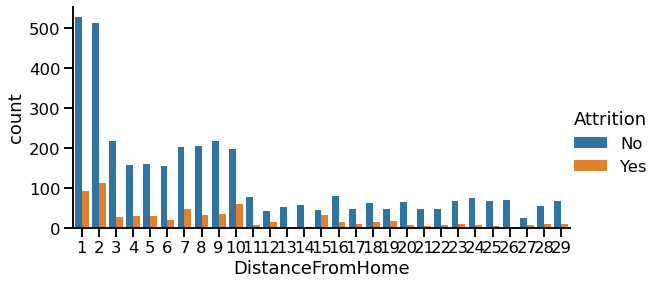

In [80]:
sns.set_context('talk', font_scale = 1)
sns.catplot(x='DistanceFromHome', hue='Attrition', data=general, kind="count", height=4, aspect=2)

In [620]:
temp_data = (general
             .groupby("DistanceFromHome")[y]
             .value_counts(normalize=True)
             .mul(100)
             .rename('percent')
             .reset_index())

In [621]:
temp_data

,DistanceFromHome,Attrition,percent
0,1,No,84.887460
1,1,Yes,15.112540
2,2,No,81.818182
3,2,Yes,18.181818
4,3,No,88.306452
5,3,Yes,11.693548
6,4,No,83.157895
7,4,Yes,16.842105
8,5,No,84.375000
9,5,Yes,15.625000


In [622]:
general.describe()

,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,meanPresenceTime,meanStartingTime,meanEndingTime,DayOfAbsence,DayOfPresence
count,4382.000000,4382.000000,4382.000000,4382.0,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.0,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000
mean,36.933364,9.198996,2.912369,1.0,2207.804884,2.063898,65061.702419,2.693291,15.210634,8.0,0.794614,11.290278,2.798266,7.010497,2.191693,4.126198,7.700561,9.991736,17.692291,24.727978,237.272022
std,9.137272,8.105396,1.024728,0.0,1271.688783,1.106115,47142.310175,2.497832,3.663007,0.0,0.852397,7.785717,1.289402,6.129351,3.224994,3.569674,1.341228,0.018149,1.341414,5.497935,5.497935
min,18.000000,1.000000,1.000000,1.0,1.000000,1.000000,10090.000000,0.000000,11.000000,8.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.950504,9.929079,15.942330,13.000000,226.000000
25%,30.000000,2.000000,2.000000,1.0,1108.250000,1.000000,29110.000000,1.000000,12.000000,8.0,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000,6.667690,9.979582,16.652977,20.000000,233.000000
50%,36.000000,7.000000,3.000000,1.0,2208.500000,2.000000,49190.000000,2.000000,14.000000,8.0,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000,7.406967,9.991953,17.400237,25.000000,237.000000
75%,43.000000,14.000000,4.000000,1.0,3308.750000,3.000000,83790.000000,4.000000,18.000000,8.0,1.000000,15.000000,3.000000,9.000000,3.000000,7.000000,8.365218,10.003486,18.351950,29.000000,242.000000
max,60.000000,29.000000,5.000000,1.0,4409.000000,5.000000,199990.000000,9.000000,25.000000,8.0,3.000000,40.000000,6.000000,40.000000,15.000000,17.000000,11.030960,10.069684,21.058616,36.000000,249.000000


In [623]:
data = general["DistanceFromHome"].value_counts()

<AxesSubplot:>

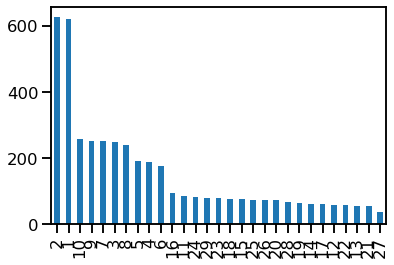

In [624]:
data.plot.bar()

<AxesSubplot:>

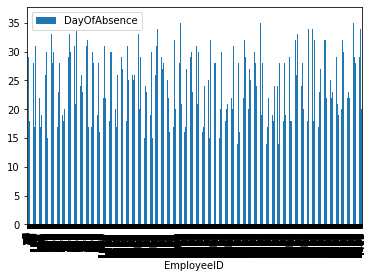

In [625]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 300))
sum_absence_day_df.plot(x ="EmployeeID", y = "DayOfAbsence", kind = "bar")
plt.show()

In [86]:
general

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,meanPresenceTime,meanStartingTime_x,meanStartingTime_y,meanEndingTime,DayOfAbsence_x,DayOfAbsence_y,DayOfPresence
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1,0,0,7.373651,9.993032,9.993032,17.367170,29,29,233
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,5,1,4,7.718969,9.980720,9.980720,17.698446,25,25,237
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5,0,3,7.013240,10.016598,10.016598,17.030096,19,19,243
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,8,7,5,7.193678,9.973830,9.973830,17.167305,26,26,236
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,6,0,4,8.006175,9.990068,9.990068,17.996327,16,16,246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,No,Travel_Rarely,Research & Development,5,4,Medical,1,4406,Female,...,3,0,2,8.522277,10.011317,10.011317,18.533539,18,18,244
4406,29,No,Travel_Rarely,Research & Development,2,4,Medical,1,4407,Male,...,3,0,2,6.092954,9.996196,9.996196,16.089281,20,20,242
4407,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,1,4408,Male,...,4,1,2,7.706632,9.971501,9.971501,17.678427,30,30,232
4408,42,No,Travel_Rarely,Sales,18,2,Medical,1,4409,Male,...,9,7,8,9.492595,10.010650,10.010650,19.502974,20,20,242


In [646]:
time_category_df = general.copy()

In [647]:
time_category_df['meanPresenceTime'] = pd.cut(time_category_df['meanPresenceTime'], bins=10, include_lowest=True)

In [648]:
time_category_df['meanPresenceTime']

2000      (6.459, 6.967]
565       (6.967, 7.475]
1385      (6.459, 6.967]
568       (6.459, 6.967]
3700      (5.944, 6.459]
              ...       
2982      (6.459, 6.967]
3767      (5.944, 6.459]
78      (10.015, 10.523]
431       (5.944, 6.459]
4019      (6.459, 6.967]
Name: meanPresenceTime, Length: 4382, dtype: category
Categories (10, interval[float64]): [(5.944, 6.459] < (6.459, 6.967] < (6.967, 7.475] < (7.475, 7.983] ... (8.999, 9.507] < (9.507, 10.015] < (10.015, 10.523] < (10.523, 11.031]]

In [649]:
time_category_df

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,meanPresenceTime,meanStartingTime,meanEndingTime,DayOfAbsence,DayOfPresence
2000,20-30 ans,No,Travel_Rarely,Research & Development,1-5,3,Life Sciences,1,2001,Male,2,Healthcare Representative,Single,74570,3.0,Y,11,8,2,10.0,1,8,1,7,"(6.459, 6.967]",9.978857,16.547245,19,243
565,20-30 ans,No,Travel_Frequently,Research & Development,1-5,4,Medical,1,566,Male,3,Research Scientist,Divorced,27160,0.0,Y,18,8,0,8.0,2,7,1,1,"(6.967, 7.475]",9.980675,17.082902,29,233
1385,20-30 ans,No,Non-Travel,Sales,1-5,3,Medical,1,1386,Female,1,Sales Executive,Divorced,54700,1.0,Y,18,8,1,12.0,2,12,6,10,"(6.459, 6.967]",10.010213,16.819433,26,236
568,30-40 ans,No,Travel_Rarely,Research & Development,1-5,3,Medical,1,569,Female,1,Human Resources,Married,38160,1.0,Y,13,8,2,7.0,2,7,5,0,"(6.459, 6.967]",10.006490,16.530605,35,227
3700,30-40 ans,No,Travel_Rarely,Sales,1-5,3,Marketing,1,3701,Male,2,Research Scientist,Single,35050,1.0,Y,12,8,2,10.0,2,10,1,8,"(5.944, 6.459]",9.999410,16.290413,35,227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2982,40-50 ans,No,Travel_Rarely,Research & Development,25-30,1,Life Sciences,1,2983,Male,1,Laboratory Technician,Single,23790,1.0,Y,12,8,0,22.0,6,22,0,4,"(6.459, 6.967]",9.973529,16.898669,23,239
3767,30-40 ans,Yes,Travel_Frequently,Research & Development,25-30,3,Life Sciences,1,3768,Female,2,Healthcare Representative,Single,25150,1.0,Y,14,8,0,7.0,3,7,7,7,"(5.944, 6.459]",10.004272,16.398389,23,239
78,20-30 ans,Yes,Travel_Rarely,Research & Development,25-30,3,Medical,1,79,Female,1,Research Scientist,Married,23070,1.0,Y,13,8,1,7.0,0,7,0,7,"(10.015, 10.523]",9.978768,20.456522,31,231
431,<20 ans,Yes,Travel_Rarely,Research & Development,25-30,3,Life Sciences,1,432,Female,3,Laboratory Technician,Single,27070,1.0,Y,11,8,0,1.0,2,1,0,0,"(5.944, 6.459]",9.989118,16.071832,19,243


In [650]:
general

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,meanPresenceTime,meanStartingTime,meanEndingTime,DayOfAbsence,DayOfPresence
2000,20-30 ans,No,Travel_Rarely,Research & Development,1-5,3,Life Sciences,1,2001,Male,2,Healthcare Representative,Single,74570,3.0,Y,11,8,2,10.0,1,8,1,7,6.568143,9.978857,16.547245,19,243
565,20-30 ans,No,Travel_Frequently,Research & Development,1-5,4,Medical,1,566,Male,3,Research Scientist,Divorced,27160,0.0,Y,18,8,0,8.0,2,7,1,1,7.102372,9.980675,17.082902,29,233
1385,20-30 ans,No,Non-Travel,Sales,1-5,3,Medical,1,1386,Female,1,Sales Executive,Divorced,54700,1.0,Y,18,8,1,12.0,2,12,6,10,6.809022,10.010213,16.819433,26,236
568,30-40 ans,No,Travel_Rarely,Research & Development,1-5,3,Medical,1,569,Female,1,Human Resources,Married,38160,1.0,Y,13,8,2,7.0,2,7,5,0,6.523464,10.006490,16.530605,35,227
3700,30-40 ans,No,Travel_Rarely,Sales,1-5,3,Marketing,1,3701,Male,2,Research Scientist,Single,35050,1.0,Y,12,8,2,10.0,2,10,1,8,6.290198,9.999410,16.290413,35,227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2982,40-50 ans,No,Travel_Rarely,Research & Development,25-30,1,Life Sciences,1,2983,Male,1,Laboratory Technician,Single,23790,1.0,Y,12,8,0,22.0,6,22,0,4,6.925647,9.973529,16.898669,23,239
3767,30-40 ans,Yes,Travel_Frequently,Research & Development,25-30,3,Life Sciences,1,3768,Female,2,Healthcare Representative,Single,25150,1.0,Y,14,8,0,7.0,3,7,7,7,6.394127,10.004272,16.398389,23,239
78,20-30 ans,Yes,Travel_Rarely,Research & Development,25-30,3,Medical,1,79,Female,1,Research Scientist,Married,23070,1.0,Y,13,8,1,7.0,0,7,0,7,10.477789,9.978768,20.456522,31,231
431,<20 ans,Yes,Travel_Rarely,Research & Development,25-30,3,Life Sciences,1,432,Female,3,Laboratory Technician,Single,27070,1.0,Y,11,8,0,1.0,2,1,0,0,6.083652,9.989118,16.071832,19,243
